# Acoustic Features

- **Author**: Dan O'Connor
- **Notebook**: 2 of 9

The purpose of this notebook is to demonstrate the process of extracting acoustic features from an MP3 audio sample. The aim is to provide an overview of the field of Music Information Retrieval (MIR) and to gain insight into the features used for music genre classification in the following notebooks. Note, I did not extract these features myself for the dataset, but rather just go through a single sample to show the process. 

The acoustic features extracted here are the same features in the `features.csv` which contains the pre-extracted features from which the modeling was done on. Timbre-related features are those that are related to the perceived sound quality, the dynamics-related features are those that are related to the loudness and intensity of the music, and the spectral-related features are those that are related to the frequency content of the music. The features are:

**Dynamics-related features:**

- Zero Crossing Rate (`ZCR`)
- Root Mean Square Energy (`RMSE`)

**Timbre-related features:**

- Chroma features computed using Short Time Fourier Transform (`chroma_stft`)
- Mel Frequency Cepstral Coefficients (`MFCC`)
- Chroma features computed using Constant-Q Transform (`chroma_cqt`) 
- Chroma features computed using Constant Energy Normalized Specific (`chroma_cens`)
- Tonnetz (`tonnetz`)

**Spectral-related features:**

- Spectral Centroid (`spectral_centroid`)
- Spectral Bandwidth (`spectral_bandwidth`)
- Spectral Roll Off (`spectral_rolloff`)
- Spectral Contrast (`spectral_contrast`)

For each one of these features the mean, standard deviation, skewness, kurtosis, median, minimum and maximum values are calculated across all frames to compress each metric to a single value. A quick description of each statistical measure:
- **Mean**: The average of the feature values across all frames. It is a measure of the central tendency.
- **Standard deviation**: A measure of the spread of the feature values around the mean. It quantifies how much the feature values deviate from the average value.
- **Skewness**: A measure of the asymmetry of the distribution of the feature values.
- **Kurtosis**: A measure of the peakedness of the distribution of the feature values. It measures the degree to which the distribution is more or less peaked than a normal distribution.
- **Median**: The middle value of the sorted feature values.
- **Minimum**: The smallest value of the feature across all frames.
- **Maximum**: The largest value of the feature across all frames.

## Table of Contents
[Dynamics Related Features](#Dynamics-Related-Features)
- [Zero Crossing Rate](#Zero-Crossing-Rate)
- [Root Mean Square Energy](#Root-Mean-Square-Energy)
<br>

[Timbre Related Features](#Timbre-Related-Features)
- [Chroma STFT](#Chroma-STFT)
- [MFCC](#MFCC)
- [Chroma CQT](#Chroma-CQT)
- [Chroma Cens](#Chroma-Cens)
- [Tonnetz](#Tonnetz)
<br>

[Spectral Related Features](#Spectral-Related-Features)
- [Spectral Centroid](#Spectral-Centroid)
- [Spectral Bandwidth](#Spectral-Bandwidth)
- [Spectral Roll Off](#Spectral-Roll-Off)
- [Spectral Contrast](#Spectral-Contrast)

We will be extracting the features a classical song from the Free Music Archieve (FMA) called 'Bach, Prelude, BWV 855a, Siloti transcription' by Felipe Sarro. The first step is to import the required libraries. The library needed for acoustic feature extraction is called `librosa`. It contains the necessary functions for loading and processing audio files, as well as computing various acoustic features. 

In [9]:
import librosa  #feature extraction library
import matplotlib.pyplot as plt
from scipy import stats
import IPython.display as ipd 
import numpy as np
%matplotlib inline

The first step in the acoustic feature extraction process is to load the audio file using librosa. For the purpose of this notebook, we have limited the song duration to 15 seconds, so that the song can be listened to throughout the notebook and visualized in the graphs of certain features to help bring intuition as to what is being extracted. The librosa.load function is used to load the audio file into a time series y and a sample rate sr. The y array represents the normalized amplitude (-1 to 1) from each sample of the audio file, and sr returns the native sampling rate of the audio. In this example, duration is set to 15.0 to load only the first 15 seconds of the audio file, and mono is set to True to convert any stereo audio to a single mono channel.

In [10]:
y, sr = librosa.load('Audio/Felipe Sarro - Bach, Prelude, BWV 855a, Siloti transcription.mp3', # mp3 file
                     sr=None, # None indiciates that it will sample the audio at the native sampling rate
                     duration = 15.0, # duration of the audio 
                     mono=True) # If audio is multi-channeled, will average left and right to single channel


# Note that the length of the array x is simply the duration multiplied by the sample rate (48,000 sample/sec x 15 s = 720,000 samples)
print(f'Sample rate: {sr} Hz\nLength of y: {len(y)} samples')

Sample rate: 48000 Hz
Length of y: 720000 samples


In [11]:
48000*15


720000

The clip of the song can be listened to below:


In [12]:
ipd.Audio(y, rate=sr) # From the array x with the sr, the audio can be reconstructed and played

Below is the waveform of the audio, which shows the changes in the normalized amplitude over the sample duration. As an intuition, the absolute value of the amplitude can be thought of as the sound being more intense or loud. A waveform generally shows the overall loudness dynamic of a song throughout the duration.

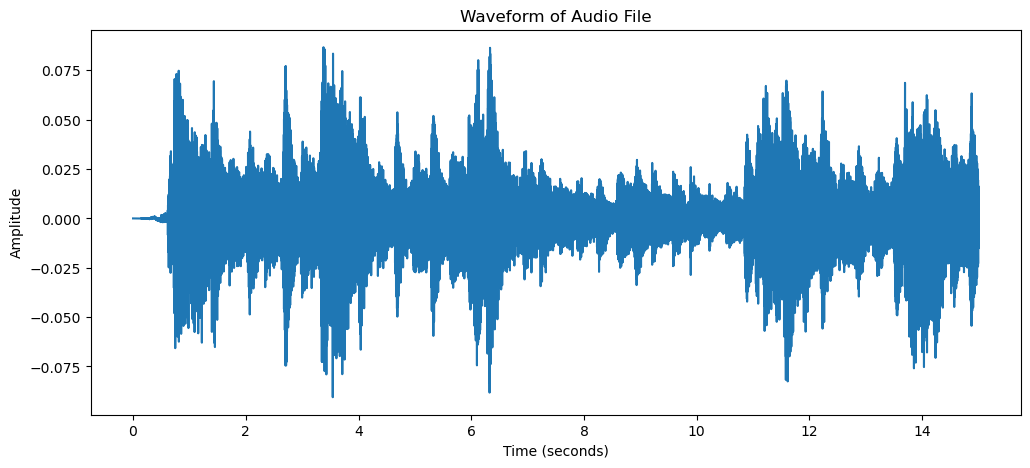

In [13]:
plt.figure(figsize=(12, 5))
plt.plot(np.arange(len(y)) / sr, y)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Waveform of Audio File')
plt.show()

## Dynamics Related Features

The two features in this section are zero crossing rate and root mean square energy. These features are explained below.

### Zero Crossing Rate

Zero crossings occur when the amplitude of the audio signal goes from positive to negative or vise versa. It is a zero crossing when the sign of the amplitude changes. Zero crossing rate is the count of times the signal changes sign within the `frame_length`. The `hop_length` refers to the size of the overlap between successive frames of the audio signal. The rate of the zero crossing can be a helpful metric in genre recognition as a general measure of 'busyness' of the signal

In [8]:
zcr = librosa.feature.zero_crossing_rate(y, frame_length=2048, hop_length=512)
zcr.shape # the zero crossing rate for 1407 frames, one dimensional


(1, 1407)

To give a visual representation, a horizontal red line is drawn at zero amplitude in the waveform plot. The time frame shown is 1 frame, or 2048 samples, which equates to ~0.04 seconds. The zero crossing rate (ZCR) is the number of times the audio signal crosses that red line, divided by the frame length. 

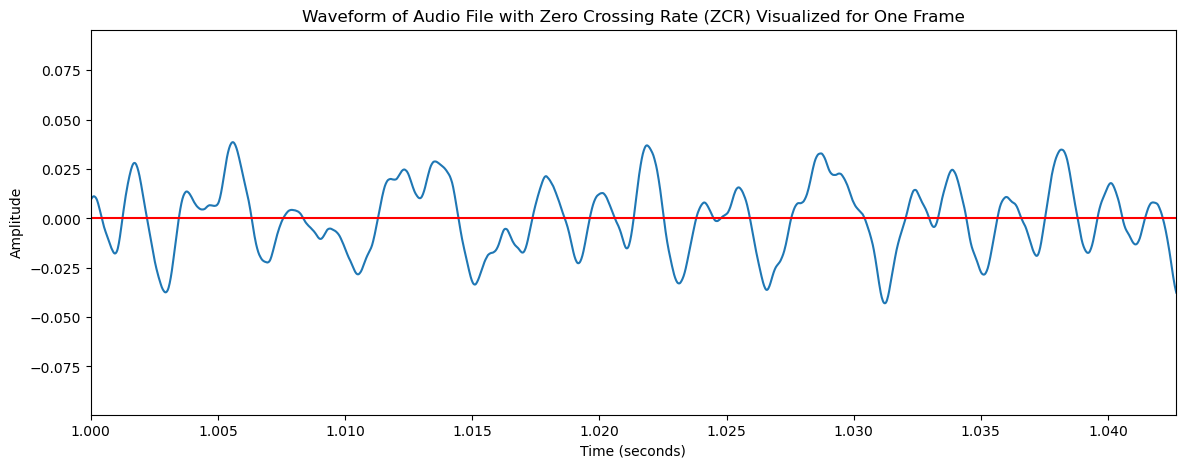

In [111]:
plt.figure(figsize=(14, 5))
plt.plot(np.arange(len(y)) / sr, y) 
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Waveform of Audio File with Zero Crossing Rate (ZCR) Visualized for One Frame')
plt.axhline(y=0, color='r')
plt.xlim([1,1+ 2048/sr]) # limit the x-axis to 2048 samples, or 1 frame, as specificed in `frame_length`
plt.show()


### Root Mean Square Energy

RMSE is a measure of the energy of the signal, or the average power. It is a useful metric in representing overall loudness over time. The first step in attaining the RMSE is to transform the singnal using a short time Fourier Transform (STFT) which, simply put, allows us to view the how the frequency of the signal changes over time. 

In [20]:
stft = np.abs(librosa.stft(y, 
                           n_fft=2048, 
                           hop_length=512)) 
rmse = librosa.feature.rms(S=stft) 
rmse.shape  #one dimensional

(1, 1407)

Note that the average power is smoothed, meaning it follows the general shape of the waveform but is always a bit lower than the waveform peaks.

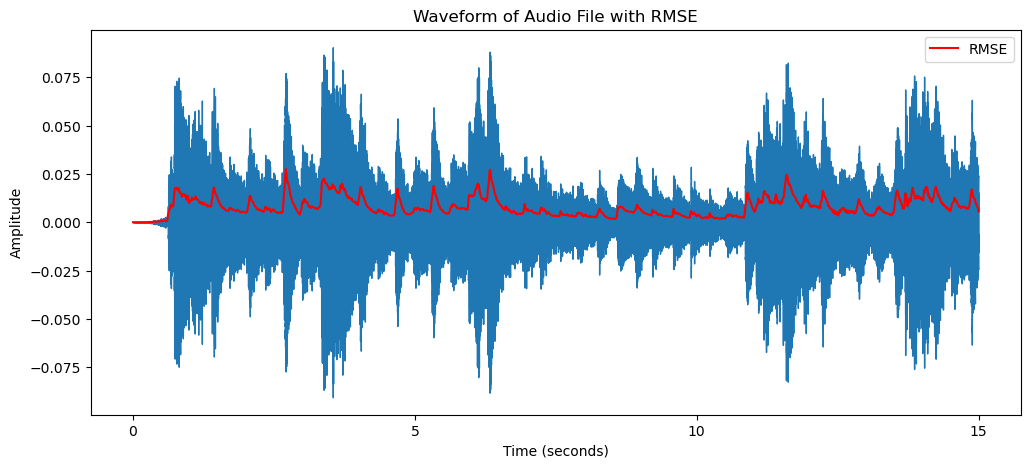

In [11]:

# Create the time array
t = librosa.frames_to_time(np.arange(len(rmse[0])), sr=sr, hop_length=512) 

# Plot the waveform and RMSE on the same figure
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y, sr=sr, axis='time', ax=plt.gca())
plt.plot(t, rmse[0], color='r', label ='RMSE')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Waveform of Audio File with RMSE')
plt.legend()
plt.show()

## Timbre Related Features

### Chroma STFT

The `chroma_stft` captures the distribution of the 12 chroma (12 notes on the Western musical scale; C, C#, D, D#, E, F, F#, G, G#, A, A#, B). This functions bins the frequencies that fall into these chroma over time. This feature is useful at capturing the harmonic structure.

In [12]:
chroma_stft = librosa.feature.chroma_stft(S=stft**2, #takes input of stft squared
                                 n_chroma=12) # number of pitches are set to 12
chroma_stft.shape #12 dimensional, 1 for each pitch

(12, 1407)

In [13]:
ipd.Audio(y, rate=sr) 

The colors in the plot represents the strength of the corresponding chroma at that time frame. It can be useful in identifying patterns of musical harmony and tonality in audio signals.

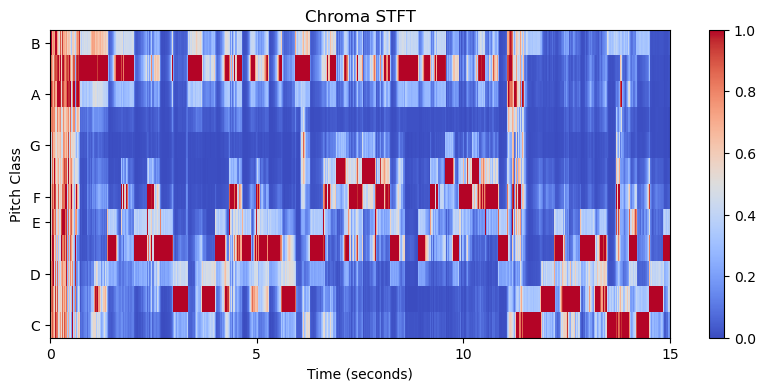

In [14]:
#plot chroma stft
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma_stft, y_axis='chroma', x_axis='time', sr=sr, hop_length=512, cmap='coolwarm')
plt.colorbar()
plt.xlabel('Time (seconds)')
plt.ylabel('Pitch Class')
plt.title('Chroma STFT')
plt.show()

### MFCC

Mel Freqeuency Cepstral Coefficients, or MFCC involves a series of transformations that filter the audio to replicate the human ear's frequency response. The result is a 20 dimensional feature vector that represent the energy in different frequency groups. More weight is given to those more relevant to human hearing.

In [17]:
mel = librosa.feature.melspectrogram(sr=sr, #using native sr
                                     S=stft**2) #sstft squared

mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel), #db is related to human hearing
                            n_mfcc=20) #setting the dims to 20
mfcc.shape #20 Dimensional 

(20, 1407)

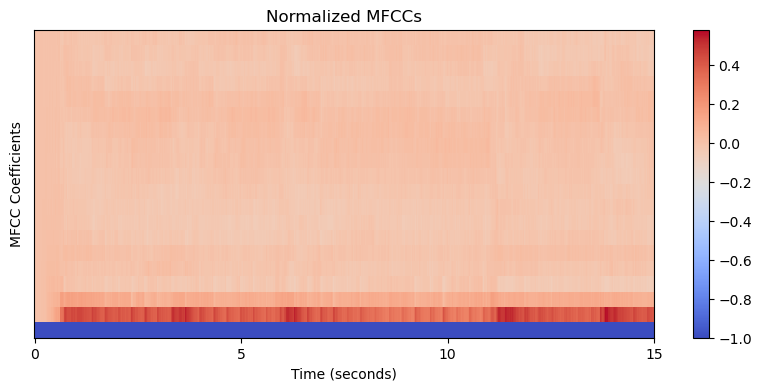

In [127]:
#plot normalized mfcc
mfcc_norm = librosa.util.normalize(mfcc) #normalize
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc_norm, x_axis='time', sr=sr, hop_length=512, cmap='coolwarm')
plt.colorbar()
plt.xlabel('Time (seconds)')
plt.ylabel('MFCC Coefficients')
plt.title('Normalized MFCCs')
plt.show()

### Chroma CQT

Chroma CQT is a method for mapping the notes to different bins to paint an overall harmonic picture of the piece of audio. It does this through applying a constant Q tranform, which divides the signal into small frequency bands then maps the the frequencies to the 12 musical notes.

In [15]:
cqt = np.abs(librosa.cqt(y, sr=sr, #natve sr
                          hop_length=512,
                          bins_per_octave=12, #12 bins per octave
                                 n_bins=7*12, 
                          tuning=None))
chroma_cqt = librosa.feature.chroma_cqt(C=cqt, n_chroma=12, n_octaves=7)    
chroma_cqt.shape

(12, 1407)

In [130]:
ipd.Audio(y, rate=sr)

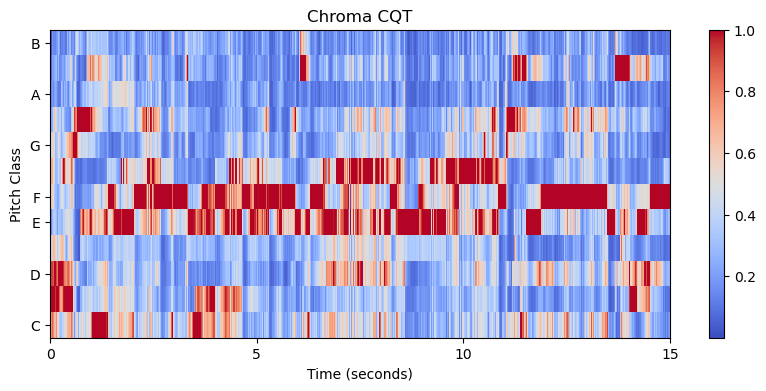

In [16]:
#plot chroma cqt
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma_cqt, y_axis='chroma', x_axis='time', sr=sr, hop_length=512, cmap='coolwarm')
plt.colorbar()
plt.xlabel('Time (seconds)')
plt.ylabel('Pitch Class')
plt.title('Chroma CQT')
plt.show()

### Chroma Cens

This feature also provides information about the overall harmonic structure of a song. It has an added normalization step involved. If you compare the chroma cens and chroma cqt graphics, they are very similar with the main difference being that chroma cqt is more 'blurry', or normalized.

In [17]:
chroma_cens = librosa.feature.chroma_cens(C=cqt, n_chroma=12, n_octaves=7)
chroma_cens.shape # 12 dimensional, one for  each pitch

(12, 1407)

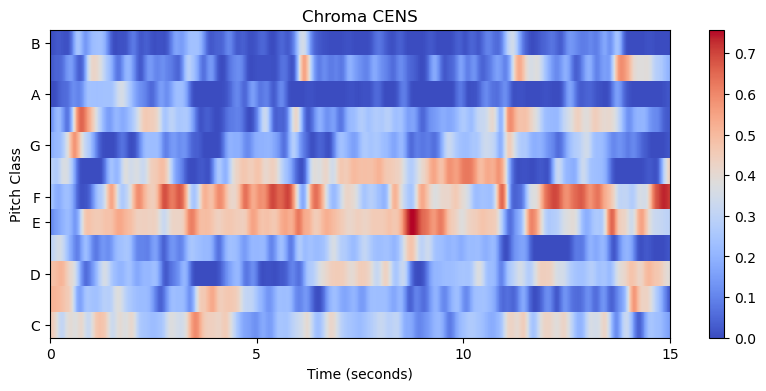

In [133]:
#plot chroma cens
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma_cens, y_axis='chroma', x_axis='time', sr=sr, hop_length=512, cmap='coolwarm')
plt.colorbar()
plt.xlabel('Time (seconds)')
plt.ylabel('Pitch Class')
plt.title('Chroma CENS')
plt.show()

### Tonnetz

Tonnetz, or tonal centroid features represents the relationship between chords and keys. The y-axis in the graphic below represents the specific interval classes. 

In [18]:
tonnetz= librosa.feature.tonnetz(chroma=chroma_cens) #takes in chromaa cens
tonnetz.shape #6 dimensional

(6, 1407)

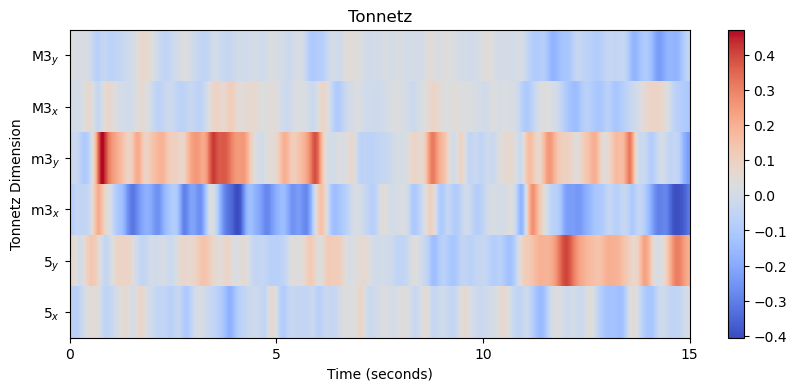

In [137]:
#plot tonnetz
plt.figure(figsize=(10, 4))
librosa.display.specshow(tonnetz, x_axis='time', y_axis='tonnetz', sr=sr, hop_length=512, cmap='coolwarm')
plt.colorbar()
plt.xlabel('Time (seconds)')
plt.ylabel('Tonnetz Dimension')
plt.title('Tonnetz')
plt.show()

## Spectral Related Features

Below shows a spectogram for the audio signal. A spectogram shows the spectral content of the signal over time.

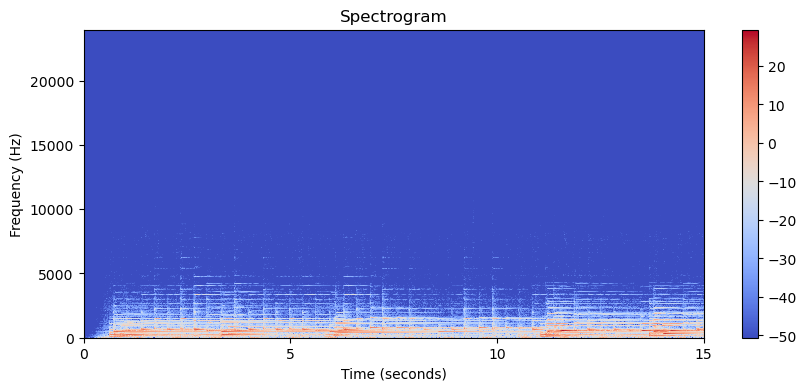

In [161]:
stft = librosa.stft(y, n_fft=2048, hop_length=512)

# Obtain frequency values from STFT
freqs = librosa.fft_frequencies(sr=sr, n_fft=2048)

# Convert frames to time
times = librosa.frames_to_time(range(stft.shape[1]), sr=sr, hop_length=512)


#plot spectogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.amplitude_to_db(abs(stft), ref=1.0), sr=sr, y_axis='linear', x_axis='time', cmap='coolwarm')
plt.colorbar()
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram')
plt.show()

### Spectral Centroid

Spectral centroid measures the 'center of mass' of the frequencies within the signal.

In [21]:
spectral_centroid = librosa.feature.spectral_centroid(S=stft)
spectral_centroid.shape #1 dimension

(1, 1407)

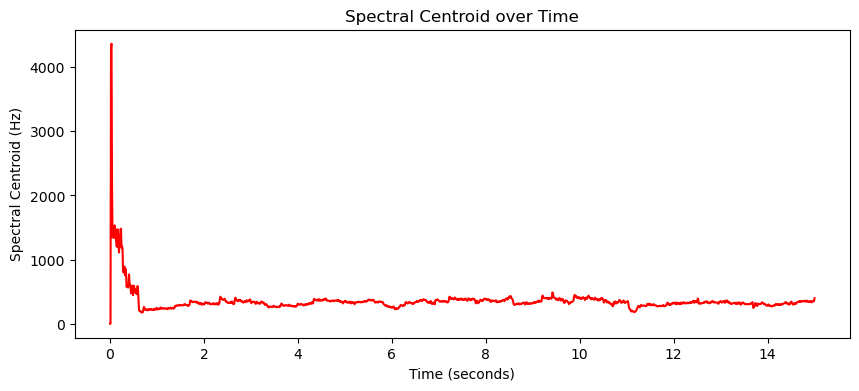

In [146]:
#plot spectral centroid

# Convert frames to time
t = librosa.frames_to_time(range(spectral_centroid.shape[1]), sr=sr)

# Plot spectral centroid against time
plt.figure(figsize=(10, 4))
plt.plot(t, spectral_centroid[0], c='red',label='Spectral Centroid')
plt.xlabel('Time (seconds)')
plt.ylabel('Spectral Centroid (Hz)')
plt.title('Spectral Centroid over Time')
plt.show()

### Spectral Bandwidth

Spectral bandwidth is the measure of the range of frequencies that contribute to the energy of the signal. 

In [23]:
spectral_bandwidth = librosa.feature.spectral_bandwidth(S=stft)
spectral_bandwidth.shape #1 dimension

(1, 1407)

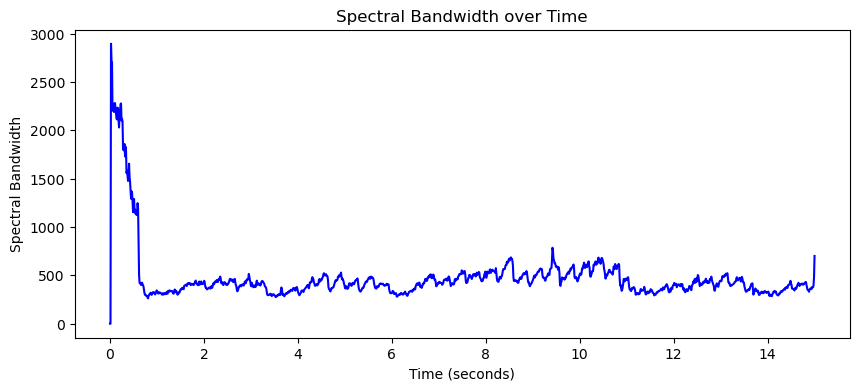

In [148]:

#plot spectral bandwidth
plt.figure(figsize=(10, 4))
plt.plot(t, spectral_bandwidth[0], c='blue',label='Spectral Bandwidth')
plt.xlabel('Time (seconds)')
plt.ylabel('Spectral Bandwidth')
plt.title('Spectral Bandwidth over Time')
plt.show()

### Spectral Roll Off 

Spectral roll off can be used to determine the 'steepness' of the slope of the freq. spectrum.

In [ ]:
spectral_rolloff = librosa.feature.spectral_rolloff(S=stft)

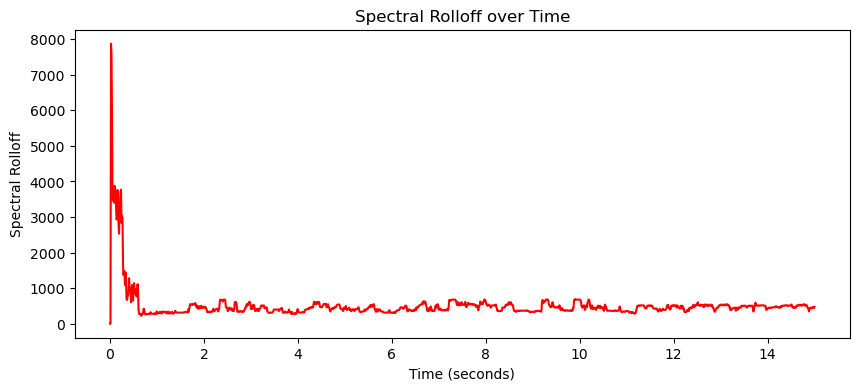

In [156]:
#plot spectral rolloff
plt.figure(figsize=(10, 4))
plt.plot(t, spectral_rolloff[0], c='red',label='Spectral Rolloff')
plt.xlabel('Time (seconds)')
plt.ylabel('Spectral Rolloff')
plt.title('Spectral Rolloff over Time')
plt.show()

The graphic below shows the previous three spectral features plotted on top of each other. They generally follow a similar pattern, however it is clear the spectral centroid doesn't peak as much as the other two.

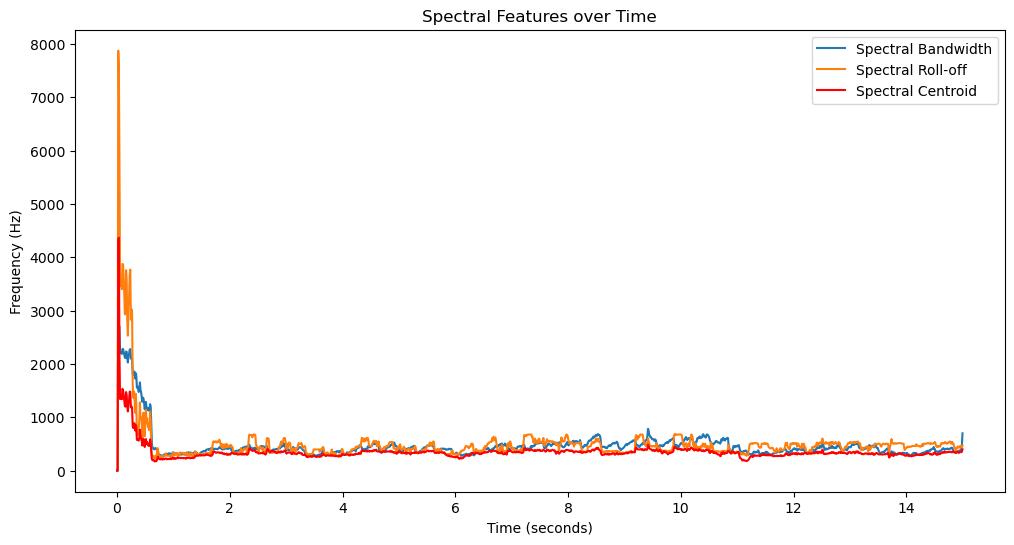

In [157]:
plt.figure(figsize=(12, 6))

# Spectral Bandwidth
plt.plot(t, spectral_bandwidth[0], label='Spectral Bandwidth')

# Spectral Roll-off
plt.plot(t, spectral_rolloff[0], label='Spectral Roll-off')

# Spectral Centroid
plt.plot(t, spectral_centroid[0], c='red', label='Spectral Centroid')

plt.xlabel('Time (seconds)')
plt.title('Spectral Features over Time')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.show()

### Spectral Contrast

Spectral contrast measures the difference between the spectral energy in the different freq. bands of the audio clip.

C:\Users\oconn\anaconda3\lib\site-packages\librosa\feature\spectral.py:523: ComplexWarning:

Casting complex values to real discards the imaginary part

C:\Users\oconn\anaconda3\lib\site-packages\librosa\feature\spectral.py:524: ComplexWarning:

Casting complex values to real discards the imaginary part



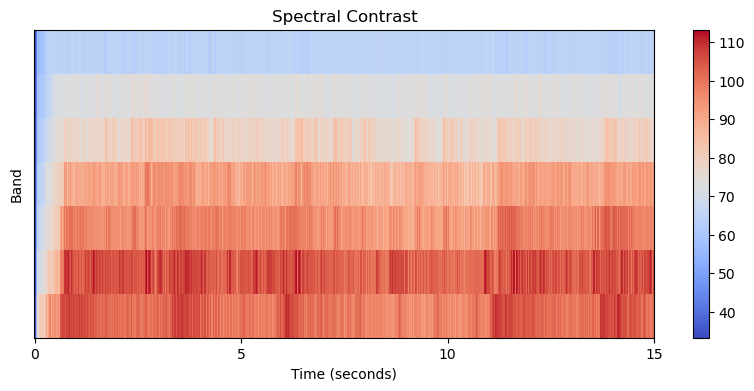

In [164]:
spectral_contrast = librosa.feature.spectral_contrast(S=stft, n_bands=6)
t = librosa.frames_to_time(range(spectral_contrast.shape[1]), sr=sr, hop_length=512)

#plot spectral contrast
plt.figure(figsize=(10, 4))
librosa.display.specshow(spectral_contrast, x_axis='time', sr=sr, hop_length=512, cmap='coolwarm')
plt.colorbar()
plt.xlabel('Time (seconds)')
plt.ylabel('Band')
plt.title('Spectral Contrast')
plt.show()